<a href="https://colab.research.google.com/github/SinghAnkit1010/Tensorflow-object-detection/blob/main/Tensorflow_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from skimage import io
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
df = pd.read_csv("/content/drive/MyDrive/_object/_annotations.csv",header = None)

In [3]:
img = []
path = "/content/drive/MyDrive/_object/"
for filename in df[0]:
    image = io.imread(os.path.join(path + filename))
    img.append(image)
image = np.array(img)

In [4]:
df

,0,1,2,3,4,5
0,dogs_002_jpg.rf.13f6245a0dd7746724303b8a912507...,94,113,263,390,dog
1,cats_005_jpg.rf.f8d4beb06cf3b6441b93e5c8d963ed...,110,11,543,571,cat
2,cats_003_jpg.rf.ce523402358a0f4ad04adc6851117a...,106,0,551,575,cat
3,dogs_001_jpg.rf.61e7a0fe5a07b1fa4cf3b6ab1b7843...,23,55,579,545,dog
4,cats_001_jpg.rf.20383aa725e81abeecf414e9ff72f7...,186,3,471,636,cat
5,cats_002_jpg.rf.0679ebb677b8b3f0096aa9f1db62eb...,235,57,640,598,cat
6,dogs_005_jpg.rf.d9b3bdbeb1c03c884017d2c1538bd2...,10,3,580,630,dog
7,dogs_003_jpg.rf.0d7ec91f8cbd37515c23113d9f6eda...,83,29,414,482,dog
8,cats_004_jpg.rf.0741a0cd24a391ee31b83c8287fe9a...,151,3,536,478,cat


In [5]:
labels = df.iloc[:,-1].values
box = list(df.iloc[:,1:-1].values.astype("float64"))

In [6]:
box

[array([ 94., 113., 263., 390.]),
 array([110.,  11., 543., 571.]),
 array([106.,   0., 551., 575.]),
 array([ 23.,  55., 579., 545.]),
 array([186.,   3., 471., 636.]),
 array([235.,  57., 640., 598.]),
 array([ 10.,   3., 580., 630.]),
 array([ 83.,  29., 414., 482.]),
 array([151.,   3., 536., 478.])]

In [7]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [8]:
labels

array([1, 0, 0, 1, 0, 0, 1, 1, 0])

In [9]:
box

[array([ 94., 113., 263., 390.]),
 array([110.,  11., 543., 571.]),
 array([106.,   0., 551., 575.]),
 array([ 23.,  55., 579., 545.]),
 array([186.,   3., 471., 636.]),
 array([235.,  57., 640., 598.]),
 array([ 10.,   3., 580., 630.]),
 array([ 83.,  29., 414., 482.]),
 array([151.,   3., 536., 478.])]

In [10]:
for i in range(len(box)):
  box[i] = box[i].reshape(1,box[i].shape[0])
  box[i] /= 256

In [11]:
num_class = 2
category_index = {1: {"id":1,"name":"cat"},2: {"id":2,"name":"dog"}}
label_id_offset = 1
train_image = []
classes  =[]
boxes = []
for (train_image_np,gt_box_np,label) in zip(image,box,labels):
  train_image.append(tf.expand_dims(tf.convert_to_tensor(train_image_np,dtype = tf.float32),axis = 0))
  boxes.append(tf.convert_to_tensor(gt_box_np,dtype = tf.float32))
  classes.append(tf.reshape(tf.one_hot(tf.convert_to_tensor(label,dtype=tf.int32),num_class),[1,num_class]))

In [12]:
classes

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>]

In [13]:
boxes

[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.3671875 , 0.44140625, 1.0273438 , 1.5234375 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.4296875 , 0.04296875, 2.1210938 , 2.2304688 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.4140625, 0.       , 2.1523438, 2.2460938]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.08984375, 0.21484375, 2.2617188 , 2.1289062 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.7265625 , 0.01171875, 1.8398438 , 2.484375  ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.91796875, 0.22265625, 2.5       , 2.3359375 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.0390625 , 0.01171875, 2.265625  , 2.4609375 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.32421875, 0.11328125, 1.6171875 , 1.8828125 ]], dtype=float32)>,
 <tf.Tensor: shape=(

In [14]:
def create_mini_batch(train_image,box,classes,batch_size):
  mini_batches = []
  all_keys = list(range(len(train_image)))
  np.random.shuffle(all_keys)
  num_batches = (len(train_image)) // batch_size
  for i in range(num_batches + 1):
    example_keys = all_keys[i*batch_size : (i+1)*batch_size]
    gt_box = [box[key] for key in example_keys]
    gt_classes = [classes[key] for key in example_keys]
    image_tensors = [train_image[key] for key in example_keys]
    x = image_tensors
    y = (gt_box,gt_classes)
    mini_batches.append((x,y))
  if(len(train_image) % batch_size != 0):
    example_keys = all_keys[i*batch_size:]
    gt_box = [box[key] for key in example_keys]
    gt_classes = [classes[key] for key in example_keys]
    image_tensors = [train_image[key] for key in example_keys]
    x = image_tensors
    y = (gt_box,gt_classes)
    mini_batches.append((x,y))
  return mini_batches

In [15]:
batch_size = 8
mini_batches = create_mini_batch(train_image,boxes,classes,batch_size)

In [16]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2023-05-18 18:55:45--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.119.128, 2a00:1450:4013:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.119.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   240MB/s    in 1.0s    

2023-05-18 18:55:46 (240 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [17]:
tf.keras.backend.clear_session()

pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"
checkpoint_path = "/content/models/research/object_detection/test_data/checkpoint/ckpt-0"

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs["model"]
train_config = configs["train_config"]
model_config.ssd.num_classes = 2
model_config.ssd.freeze_batchnorm = True
train_config.batch_size = 8
detection_model = model_builder.build(model_config = model_config,is_training = True) 

fake_box_predictor = tf.compat.v2.train.Checkpoint(_base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
                                                   _box_prediction_head = detection_model._box_predictor._box_prediction_head)
fake_model = tf.compat.v2.train.Checkpoint(_feature_extractor = detection_model._feature_extractor,
                                           box_predictor = fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model = fake_model)
ckpt.restore(checkpoint_path).expect_partial()

images,shapes = detection_model.preprocess(tf.zeros([1,640,640,3]))
prediction_dict = detection_model.predict(images,shapes)
_ = detection_model.postprocess(prediction_dict,shapes)
print("weights restored!")

weights restored!


In [18]:
prefixes_to_train = ["WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead",
                     "WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead"]

to_fine_tune = []
for variable in detection_model.trainable_variables:
  if any([variable.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(variable)

Loss = []

def model_train_step(model,optimizer,vars_to_fine_tune):
  def train_step(image_tensors,gt_box_list,gt_class_list):
    batch_size = 8
    shapes = tf.constant(batch_size * [[640,640,3]],dtype = tf.float32)
    model.provide_groundtruth(groundtruth_boxes_list=gt_box_list,groundtruth_classes_list = gt_class_list)
    with tf.GradientTape() as tape:  
      preprocessed_images = tf.concat([model.preprocess(image_tensor)[0] for image_tensor in image_tensors],axis = 0)
      predict_dict = model.predict(preprocessed_images,shapes)
      losses_dict = model.loss(predict_dict,shapes)
      total_loss = losses_dict["Loss/localization_loss"] + losses_dict["Loss/classification_loss"]
    gradients = tape.gradient(total_loss,vars_to_fine_tune)
    optimizer.apply_gradients(zip(gradients,vars_to_fine_tune))
    return total_loss
  return train_step

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
train_step = model_train_step(detection_model,optimizer,to_fine_tune)

for epochs in range(50):
  total_loss = 0
  for batches in mini_batches:
    x,y = batches
    y1,y2 = y
    loss = train_step(x,y1,y2)
    total_loss = loss + total_loss
  Loss.append(total_loss.numpy())
  print('epoch ' + str(epochs+1) + ': loss=' +  str(total_loss.numpy()))

epoch 1: loss=8.935458
epoch 2: loss=8.525946
epoch 3: loss=8.209112
epoch 4: loss=7.9302497
epoch 5: loss=7.6710725
epoch 6: loss=7.4236684
epoch 7: loss=7.1844454
epoch 8: loss=6.951269
epoch 9: loss=6.722474
epoch 10: loss=6.4965587
epoch 11: loss=6.2725515
epoch 12: loss=6.0499296
epoch 13: loss=5.82839
epoch 14: loss=5.6080217
epoch 15: loss=5.389008
epoch 16: loss=5.17167
epoch 17: loss=4.9562855
epoch 18: loss=4.7429667
epoch 19: loss=4.531784
epoch 20: loss=4.3229914
epoch 21: loss=4.1206036
epoch 22: loss=3.9274457
epoch 23: loss=3.743728
epoch 24: loss=3.5691812
epoch 25: loss=3.4033074
epoch 26: loss=3.245537
epoch 27: loss=3.095199
epoch 28: loss=2.9516206
epoch 29: loss=2.8141599
epoch 30: loss=2.6822891
epoch 31: loss=2.555573
epoch 32: loss=2.4336276
epoch 33: loss=2.3160987
epoch 34: loss=2.202651
epoch 35: loss=2.0929704
epoch 36: loss=1.9867615
epoch 37: loss=1.8837491
epoch 38: loss=1.7837943
epoch 39: loss=1.6868361
epoch 40: loss=1.5927079
epoch 41: loss=1.5013998


In [19]:
epoch = list(np.arange(1,51,1))

In [ ]:
epoch

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

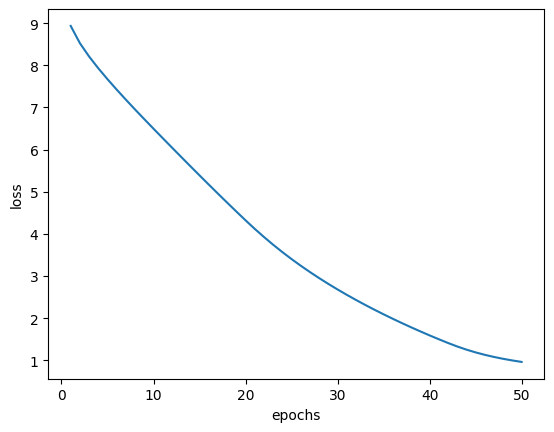

In [30]:
plt.plot(np.array(epoch),np.array(Loss))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()